# My VRP

My implementation of the Capacitated Vehicle Routing Problem (CVRP) based on the formulation given on the [wikipedia page for VRPs](https://en.wikipedia.org/wiki/Vehicle_routing_problem).

![wikipediaFormulation](./images/wikipediaFormulation.png)

#### Notes:
A distance matrix is an array whose i, j entry is the distance from location i to location j in miles, where the array indices correspond to the locations in order.

#### References/Resources:
- https://en.wikipedia.org/wiki/Vehicle_routing_problem
- https://developers.google.com/optimization/cp/cp_solver
- https://developers.google.com/optimization/mip/mip_var_array
- https://google.github.io/or-tools/python/ortools/sat/python/cp_model.html


In [177]:
# Requires Python version >= 3.8
import math
from itertools import chain, combinations
from ortools.sat.python import cp_model

In [201]:
# Constants:
vehicleCount = 4
vehicleCapacity = 40
nodeCapacity = 10

In [210]:
class VRPGraph:
    nodes = None  # an array of coordinates.  nodes[0] is the depot.
    distanceMatrix = None
    nodeSubsets = None  # A set of sets of nodes
    minVehicleCounts = None  # A dict; the keys are sets of nodes; the values are integers
    
    
    def __init__(self, nodes):
        """
        Assumes nodes[0] is the depot.
        """
        self.nodes = nodes
        self.distanceMatrix = self.nodesToDistanceMatrix(self.nodes)
        self.nodeSubsets = self.calculateNodeSubsets(self.nodes)
        self.minVehicleCounts = self.calculateMinVehicleCounts(self.nodeSubsets)
        
        
    def nodesToDistanceMatrix(self, nodes):
        """
        Calculate distances between each nodes as an integer.
        The number of operations is the sum of natural numbers up to (n-1) 
        where n is the number of nodes. This is O(n^2).
        """
        numNodes = len(nodes)
        
        # initialize the nxn matrix:
        distanceMatrix = [[0 for x in range(numNodes)] for y in range(numNodes)]
        
        for i in range(0, numNodes):
            for j in range(i, numNodes):
                curDist = int(math.dist(nodes[i], nodes[j]))
                distanceMatrix[i][j] = curDist
                distanceMatrix[j][i] = curDist
        
        return distanceMatrix
    
    
    def calculateNodeSubsets(self, nodes):
        """
        Calculate all possible subsets from the set (nodes - depot).
        Use the numbering of the nodes instead of the node itself.
        e.g. instead of depot at (0,0), use 0
        Reference: https://docs.python.org/3/library/itertools.html#itertools-recipes
        e.g. [1,2,3] --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
        """
        s = range(1, len(nodes))  # all nodes minus depot
        subsets = set(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
        subsets.remove(())  # remove the empty set.  That is, ().
        return subsets
    
    
    def calculateMinVehicleCounts(self, nodeSubsets):
        """
        Calculate the minimum number of vehicles needed to serve each subset.
        - This is trivial right now.  Will need another implementation if node
            capacity varies.
        """
        minVehicleCounts = {}
        for subset in nodeSubsets:
            minVehicleCounts[subset] = int(math.ceil((nodeCapacity * len(subset)) / vehicleCapacity))
            
        return minVehicleCounts
        

In [203]:
myCoords1 = [
    (0, 0),  # The depot
    (-10, 10),
    (20, 10),
    (10, -5),
    (-5, -5)
]

myCoords2 = [
    (0, 0),  # The depot
    (-10, 10),
    (20, 10),
    (10, -5),
    (-15, -25),
    (-30, 0),
    (40, 0),
    (15, -15),
    (-45, 20)
]

myVRPGraph = VRPGraph(myCoords2)
# print(myVRPGraph.distanceMatrix)
# print(myVRPGraph.nodeSubsets)
# print(myVRPGraph.minVehicleCounts)



#### Create Model and Variables

In [204]:
model = cp_model.CpModel()

iMax = len(myVRPGraph.nodes)
jMax = iMax

# Create the x_ij variables:
xVars = []
for i in range(0, iMax):
    xVars.append([])
    for j in range(0, jMax):
        xVars[i].append(model.NewBoolVar(name='x_{}_{}'.format(i, j)))


#### Define the constraints

In [205]:
# Constraint 1:
for j in range(1, jMax):
    # Sum cols of xVars
    model.Add(cp_model.LinearExpr.Sum(
        [xVars[i][j] for i in range(0, iMax)]) == 1)

# Constraint 2:
for i in range(1, iMax):
    # Sum rows of xVars
    model.Add(cp_model.LinearExpr.Sum(xVars[i][:]) == 1)
    
# Constraint 3:
model.Add(cp_model.LinearExpr.Sum(
    [xVars[i][0] for i in range(0, iMax)]) == vehicleCount)

# Constraint 4:
model.Add(cp_model.LinearExpr.Sum(xVars[0][:]) == vehicleCount)

# Constraint 5:
numNodes = len(myVRPGraph.nodes)
for subset in myVRPGraph.minVehicleCounts:
    complement = set(range(0, numNodes)) - set(subset)  # full set minus subset
    model.Add(cp_model.LinearExpr.Sum(
        [xVars[i][j] for i in complement for j in subset])
        >= myVRPGraph.minVehicleCounts[subset])

# Note, constraint 6 is captured by using NewBoolVar() to create variables.

#### Set Objective

In [206]:
# Can use LinearExpr to create the constraints and objective from arrays of coefficients.
objective = cp_model.LinearExpr.ScalProd(
    expressions=[xVars[i][j] for i in range(iMax) for j in range(jMax)],
    coefficients=[myVRPGraph.distanceMatrix[i][j] for i in range(iMax) for j in range(jMax)]
)

model.Minimize(objective)


#### Solve and print solution (if found)

In [207]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f'Minimum of objective function: {solver.ObjectiveValue()}\n')
    for i in range(iMax):
        print('- - - - x_{}_j - - - -'.format(i))
        print([solver.Value(xVars[i][j]) for j in range(jMax)])
else:
    print('No solution found.')

Minimum of objective function: 249.0

- - - - x_0_j - - - -
[1, 0, 1, 1, 1, 0, 0, 0, 0]
- - - - x_1_j - - - -
[1, 0, 0, 0, 0, 0, 0, 0, 0]
- - - - x_2_j - - - -
[0, 0, 0, 0, 0, 0, 1, 0, 0]
- - - - x_3_j - - - -
[1, 0, 0, 0, 0, 0, 0, 0, 0]
- - - - x_4_j - - - -
[0, 0, 0, 0, 0, 1, 0, 0, 0]
- - - - x_5_j - - - -
[0, 0, 0, 0, 0, 0, 0, 0, 1]
- - - - x_6_j - - - -
[0, 0, 0, 0, 0, 0, 0, 1, 0]
- - - - x_7_j - - - -
[1, 0, 0, 0, 0, 0, 0, 0, 0]
- - - - x_8_j - - - -
[0, 1, 0, 0, 0, 0, 0, 0, 0]


#### Visualize the graph and routes

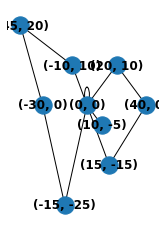

In [209]:
# Visualization:
import networkx as nx
import matplotlib.pyplot as plt

# Init Graph, nodes, and positions
G = nx.Graph()
G.add_nodes_from(myVRPGraph.nodes)
pos = {}
for n in myVRPGraph.nodes:
    pos[n] = list(n)
    
# Add edges in optimal solution:
for i in range(iMax):
    for j in range(jMax):
        if solver.Value(xVars[i][j]) == 1:
            G.add_edge(myVRPGraph.nodes[i], myVRPGraph.nodes[j])

# Draw graph
subax1 = plt.subplot(121)
nx.draw(G, pos, with_labels=True, font_weight='bold')
